## Benchmark 6: OLS model structured bootstrap resampling
Now that we have a resampling strategy that gives us at least some confidence that our internal benchmarking scores could be reflective of what will happened when we submit to the public leaderboard. Let's start working on the model. The first thing I want to try is another shot at the OLS model. Firstly, to see if we can make any clever improvements. But, mostly to generalize the functions written to resample, forecast and score the naive model.
1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Load & inspect](#load_inspect)
3. [Helper functions](#helper_functions)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

<a name="load_inspect"></a>
### 2. Load & inspect

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
#import functions.data_manipulation_functions as data_funcs

import statistics
import numpy as np
import pandas as pd
import statsmodels.api as sm
import multiprocessing as mp
import matplotlib.pyplot as plt
from statistics import NormalDist

print(f'Python: {sys.version}')
print()
print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')

Python: 3.10.0 | packaged by conda-forge | (default, Nov 20 2021, 02:24:10) [GCC 9.4.0]

Numpy 1.23.5
Pandas 1.4.3


In [2]:
# Load parsed data
block_size = 8

output_file = f'{conf.DATA_PATH}/parsed_data/structured_bootstrap_blocksize{block_size}.npy'
timepoints = np.load(output_file)

print(f'Timepoints shape: {timepoints.shape}')
print()
print('Column types:')

for column in timepoints[0,0,0,0:]:
    print(f'\t{type(column)}')

print()
print(f'Example block:\n{timepoints[0,0,0:,]}')

Timepoints shape: (31, 3135, 8, 5)

Column types:
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>
	<class 'numpy.float64'>

Example block:
[[1.0010000e+03 1.5646176e+18 3.0076818e+00 1.2490000e+03 0.0000000e+00]
 [1.0010000e+03 1.5672960e+18 2.8848701e+00 1.1980000e+03 1.0000000e+00]
 [1.0010000e+03 1.5698880e+18 3.0558431e+00 1.2690000e+03 2.0000000e+00]
 [1.0010000e+03 1.5725664e+18 2.9932332e+00 1.2430000e+03 3.0000000e+00]
 [1.0010000e+03 1.5751584e+18 2.9932332e+00 1.2430000e+03 4.0000000e+00]
 [1.0010000e+03 1.5778368e+18 2.9690900e+00 1.2420000e+03 5.0000000e+00]
 [1.0010000e+03 1.5805152e+18 2.9093256e+00 1.2170000e+03 6.0000000e+00]
 [1.0010000e+03 1.5830208e+18 2.9332314e+00 1.2270000e+03 7.0000000e+00]]


<a name="helper_functions"></a>
### 3. Helper functions

In [3]:
def two_point_smape(actual, forecast):
    '''Takes two datapoints and returns the SMAPE value for the pair'''

    # If SMAPE denominator is zero set SMAPE to zero
    if actual == 0 and forecast == 0:
        return 0

    # Calculate smape for forecast
    smape = abs(forecast - actual) / ((abs(actual) + abs(forecast)) / 2)
    
    return smape

In [4]:
def sample_parsed_data(timepoints, sample_size):
    '''Generates a random sample of sample_size from a random timepoint'''

    # Initialize random seed to make sure that output is differently random each call
    np.random.seed()

    # Pick random timepoint
    random_timepoint_index = np.random.choice(timepoints.shape[0], 1)
    timepoint = timepoints[random_timepoint_index][0]

    if sample_size == 'all':
        return timepoint

    # Pick n unique random county indexes to include in the sample
    random_county_indices = np.random.choice(timepoint.shape[0], sample_size, replace=False)

    # Use random indices to extract sample from timepoint
    sample = timepoint[random_county_indices]

    return sample

In [5]:
def make_forecast(block, model_type, model_order):
    '''Uses specified model type and model order to forecast
    within block, one timepoint into the future. Also returns
    naive, 'carry-forward' prediction for the same datapoint 
    for comparison'''

    # Get prediction for naive control
    naive_prediction = block[model_order, 2]

    if model_type == 'OLS':

        # Y input is sequential integers
        x_input = list(range(model_order))

        # X input is MBD values starting from the left
        # edge of the block, up to the model order
        y_input = list(block[:model_order, 2])

        # Forecast X input is sequential integers starting
        # after the end of the X input
        forecast_x = list(range(model_order, (model_order * 2)))

        # Fit and predict
        model = sm.OLS(y_input, sm.add_constant(x_input)).fit()
        prediction = model.predict(sm.add_constant(forecast_x))

        # Return the first forecasted value and the naive prediction control
        return prediction[0], naive_prediction

    else:
        return None

In [6]:
def model_smape_score(sample, model_type, model_order):
    '''Takes a sample of blocks, makes forecast for each 
    and collects resulting SMAPE values'''

    # Holder for SMAPE values
    smape_values = {
        'OLS_forecast': [],
        'naive_control': []
    }

    for block_num in range(sample.shape[0]):

        # Get the forecasted value - last value in the model order (input) range
        forecast_value, naive_control = make_forecast(sample[block_num], model_type, model_order)

        # Get the true value
        actual_value = sample[block_num, model_order, 2]

        # Get and collect SMAPE value for this forecast
        forecast_smape_value = two_point_smape(actual_value, forecast_value)
        smape_values['OLS_forecast'].append(forecast_smape_value)

        # Also score the control
        control_smape_value = two_point_smape(actual_value, naive_control)
        smape_values['naive_control'].append(control_smape_value)

    forecast_smape_score = (100/len(smape_values['OLS_forecast'])) * sum(smape_values['OLS_forecast'])
    control_smape_score = (100/len(smape_values['naive_control'])) * sum(smape_values['naive_control'])

    return forecast_smape_score, control_smape_score

In [7]:
def bootstrap_smape_score(timepoints, num_samples, sample_size, model_order, model_type):

    smape_scores = {
        'OLS_forecast': [],
        'naive_control': []
    }

    for i in range(num_samples):
        sample = sample_parsed_data(timepoints, sample_size)
        forecast_smape_score, control_smape_score = model_smape_score(sample, model_type, model_order)

        smape_scores['OLS_forecast'].append(forecast_smape_score)
        smape_scores['naive_control'].append(control_smape_score)

    return smape_scores

In [8]:
num_samples = 3000
sample_size = 300
model_order = 4
model_type = 'OLS'

smape_scores = bootstrap_smape_score(timepoints, num_samples, sample_size, model_order, model_type)

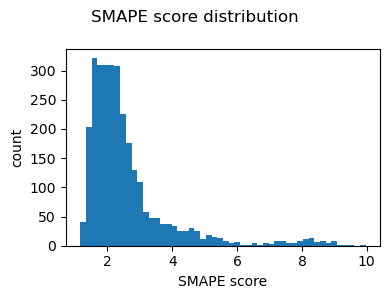

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.hist(smape_scores['OLS_forecast'], bins=50)
ax.hist(smape_scores['naive_control'], bins=50)
ax.set_xlabel('SMAPE score')
ax.set_ylabel('count')

plt.suptitle(f'SMAPE score distribution')
plt.tight_layout()